### An Audio Version of MNIST Dataset

In [162]:
import numpy as np
import IPython.display as i_dis
import os
import librosa
import librosa.display as display
import matplotlib.pyplot as plt
import tqdm

MAIN_DIR = "/home/deadpool/github/MNIST-AUDIO-CLASSIFICATION/"
DATA_DIR = os.path.join(MAIN_DIR,"mnist spoken data","recordings")
SAMPLE_DIR = os.path.join(MAIN_DIR,"samples")
LABELS = np.arange(0,10)
os.makedirs("Figures",exist_ok=True)
FIG_DIR = os.path.join(MAIN_DIR,"Figures")
# print(MAIN_DIR)

In [2]:
os.chdir(DATA_DIR)
print("Play a sample wavfile from the datset:")
i_dis.Audio("0_theo_4.wav")

Play a sample wavfile from the datset


### Prepare Dataset

In [58]:
def fetch_data():
    audio = []
    labels = []
    for file in os.listdir():
        a, SR = librosa.load(file)
        if(len(a)>13800):
            continue
        elif(len(a)<13800):
            a = np.pad(a,(0,13800-len(a)),constant_values=(0,0))
        audio.append(a)
        labels.append(file[0])
    return audio,SR,labels

In [59]:
audios, SR, labels = fetch_data()

In [60]:
sample_len = [len(x) for x in audios]

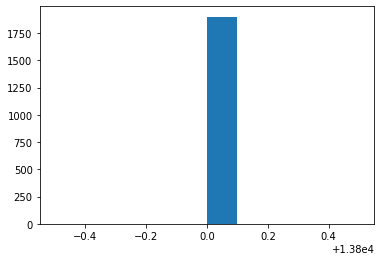

In [61]:
plt.hist(sample_len)
plt.show()

In [57]:
np.percentile(sample_len,95)

13779.4

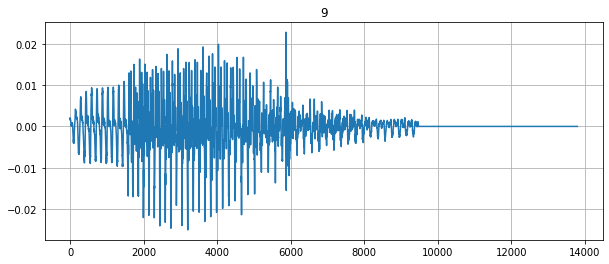

In [62]:
# librosa.display.waveplot(audios[0],sr=SR)
plt.figure(figsize=(10,4))
plt.title(labels[0])
plt.plot(audios[0])
plt.grid("ON")
plt.show()

In [65]:
mfcc = librosa.feature.mfcc(audios[0],sr=SR,n_mfcc=13,hop_length=512,n_fft=2048)

[Text(0.5, 1.0, 'MFCC')]

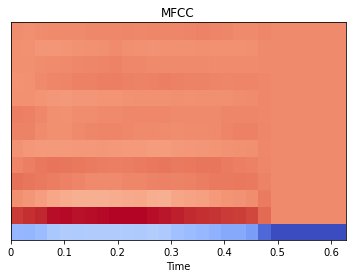

In [71]:
fig, ax = plt.subplots()
img = display.specshow(mfcc, x_axis='time', ax=ax)
# fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

In [72]:
mfcc.shape

(13, 27)

### Extract Features

In [80]:
def extract_MFCC(audio,SR,n_mfcc=13,hop_length=512,n_fft=2048):
    features = []
    for a,index in zip(audio,tqdm.tqdm( range(len(audio)),desc="Extracting Features: ")):
        mfcc = librosa.feature.mfcc(a,sr=SR,n_mfcc=n_mfcc,hop_length=hop_length,n_fft=n_fft)
        features.append(mfcc)
    return features

In [81]:
features = extract_MFCC(audios,SR)

Extracting Features: 100%|█████████▉| 1900/1901 [00:36<00:00, 52.53it/s]


In [128]:
# import tensorflow.keras as keras
import tensorflow as tf
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

In [129]:
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels).astype('float64')

In [130]:
X = np.array(features)
Y = encoded_labels

In [131]:
splitter = StratifiedShuffleSplit(n_splits=1,test_size=0.1, random_state=42)

train_id, test_id = next(splitter.split(X,Y))
X_train,y_train,X_test,y_test = X[train_id],Y[train_id],X[test_id],Y[test_id]

train_id, test_id = next(splitter.split(X_train,y_train))
X_train,y_train,X_val,y_val = X_train[train_id],y_train[train_id],X_train[test_id],y_train[test_id]

In [132]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_val = X_val[..., np.newaxis]

INPUT_SHAPE = (X_train.shape[1], X_train.shape[2], 1)

In [191]:
print(X_train[0].shape)
print(X_train.shape)
print(X_test.shape)

(13, 27, 1)
(1539, 13, 27, 1)
(191, 13, 27, 1)


In [136]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64,(3,3),activation="relu",input_shape=INPUT_SHAPE,kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

# 3rd conv layer
model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

# flatten output and feed into dense layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
tf.keras.layers.Dropout(0.3)

# softmax output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))


In [137]:
  model.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [138]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 11, 25, 64)        640       
_________________________________________________________________
batch_normalization_3 (Batch (None, 11, 25, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 13, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 11, 32)         18464     
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 11, 32)         128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 6, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 5, 32)         

In [142]:
history = model.fit(X_train,y_train,epochs=30,batch_size=30,validation_data=(X_val,y_val))

Epoch 1/30
52/52 [==============================] - 1s 23ms/step - loss: 0.5382 - accuracy: 0.9006 - val_loss: 0.9186 - val_accuracy: 0.6959
Epoch 2/30
52/52 [==============================] - 1s 22ms/step - loss: 0.3174 - accuracy: 0.9441 - val_loss: 0.4923 - val_accuracy: 0.8480
Epoch 3/30
52/52 [==============================] - 1s 22ms/step - loss: 0.2541 - accuracy: 0.9558 - val_loss: 0.2351 - val_accuracy: 0.9649
Epoch 4/30
52/52 [==============================] - 1s 22ms/step - loss: 0.1697 - accuracy: 0.9831 - val_loss: 0.2371 - val_accuracy: 0.9591
Epoch 5/30
52/52 [==============================] - 1s 21ms/step - loss: 0.1580 - accuracy: 0.9805 - val_loss: 0.3104 - val_accuracy: 0.9123
Epoch 6/30
52/52 [==============================] - 1s 21ms/step - loss: 0.1709 - accuracy: 0.9760 - val_loss: 0.3265 - val_accuracy: 0.9298
Epoch 7/30
52/52 [==============================] - 1s 23ms/step - loss: 0.1363 - accuracy: 0.9896 - val_loss: 0.2317 - val_accuracy: 0.9298
Epoch 8/30
52

In [143]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

6/6 [==============================] - 0s 8ms/step - loss: 0.1268 - accuracy: 0.9738

Test loss: 0.12676650285720825, test accuracy: 97.38219976425171


In [164]:
os.chdir(SAMPLE_DIR)

In [166]:

i_dis.Audio("nine.wav")

In [173]:
sample,sr = librosa.load("three.wav")

In [176]:
len(sample)

43008

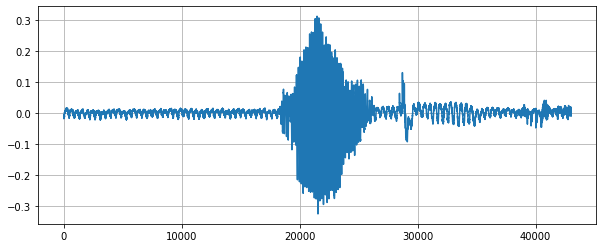

In [175]:
plt.figure(figsize=(10,4))
plt.plot(sample)
plt.grid("ON")
plt.show()

In [177]:
if(len(sample)>13800):
    off = int(len(sample)/2)
    sample =sample[off-6900:off+6900]
if(len(sample)<13800):
    sample = np.pad(sample,(0,13800-len(sample)),constant_values=(0,0))

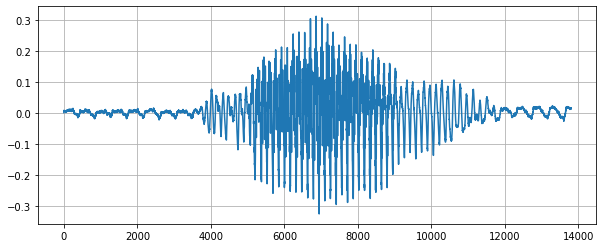

In [178]:
plt.figure(figsize=(10,4))
plt.plot(sample)
plt.grid("ON")
plt.show()

In [179]:
len(sample)

13800

In [194]:
mfcc = librosa.feature.mfcc(sample,sr=SR,n_mfcc=13,hop_length=512,n_fft=2048)

In [195]:
mfcc.shape

(13, 27)

In [196]:
mfcc = mfcc[...,np.newaxis]

In [201]:
mfcc = mfcc[np.newaxis,...]

In [202]:
mfcc.shape

(1, 13, 27, 1)

In [204]:
model.predict_classes(mfcc)

array([2])

In [209]:
for file in os.listdir():
    sample,sr = librosa.load(file)
    if(len(sample)>13800):
        off = int(len(sample)/2)
        sample =sample[off-6900:off+6900]
    if(len(sample)<13800):
        sample = np.pad(sample,(0,13800-len(sample)),constant_values=(0,0))
    mfcc = librosa.feature.mfcc(sample,sr=SR,n_mfcc=13,hop_length=512,n_fft=2048)
    mfcc = mfcc[...,np.newaxis]
    mfcc = mfcc[np.newaxis,...]
    p = model.predict_classes(mfcc)
    print(p)

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[3]
[2]
[3]


In [211]:
os.listdir()

['eight.wav',
 'three.wav',
 'one_one.wav',
 'nine.wav',
 'one.wav',
 'zero.wav',
 'seven.wav',
 'two.wav',
 'four.wav',
 'five.wav',
 'two_two.wav',
 'six.wav']